In [ ]:
#!:bash

NameError: name 'ls' is not defined

In [5]:
%pip install -r requirements.txt

%matplotlib inline
%load_ext autoreload
%autoreload 2

Note: you may need to restart the kernel to use updated packages.


Device is cuda


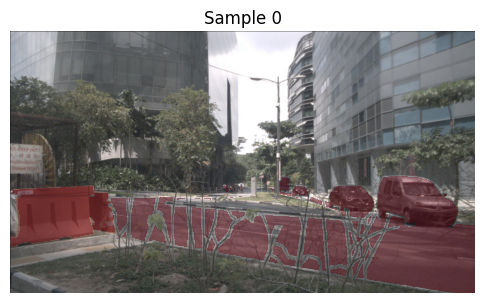

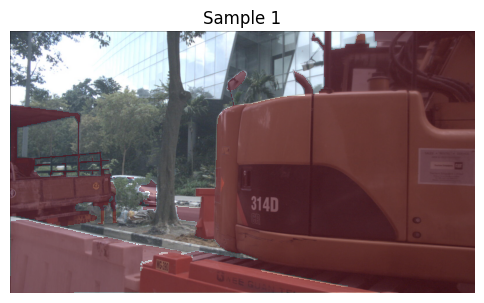

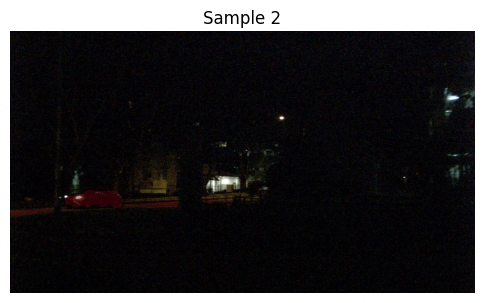

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import segmentation_models_pytorch as smp
from nuimages.nuimages import NuImages          


from train import train

# import gc

# gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

NUM_EPOCHS = 2
NUM_WORKERS = 2
BATCH_SIZE = 16
NUM_EXAMPLES=1 
FREEZE=False

class NuImagesDataset(Dataset):
    def __init__(
        self,
        dataroot,
        version,
        transform=None,
        target_transform=None,
        sensor_channels=None,
    ):
        self.nuim = NuImages(dataroot=dataroot, version=version, lazy=True, verbose=False)
        default_cams = ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT']
        cams = sensor_channels if sensor_channels is not None else default_cams

        # Filter for camera keyframes
        self.sd_tokens = [
            sd['token']
            for sd in self.nuim.sample_data
            if sd['is_key_frame'] and
               self.nuim.shortcut('sample_data','sensor',sd['token'])['channel'] in cams
        ]
        self.sd_tokens.sort()  # for reproducibility

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sd_tokens)

    def __getitem__(self, idx):
        sd_token = self.sd_tokens[idx]
        sd = self.nuim.get('sample_data', sd_token)
        img_path = os.path.join(self.nuim.dataroot, sd['filename'])
        image = Image.open(img_path).convert('RGB')

        sem_mask, _ = self.nuim.get_segmentation(sd_token)
        mask = Image.fromarray(sem_mask.astype(np.uint8))

        # Example of a joint random crop
        if self.transform and hasattr(self.transform, 'get_params'):
            i, j, h, w = self.transform.get_params(image, self.transform.size)
            image = TF.crop(image, i, j, h, w)
            mask  = TF.crop(mask,  i, j, h, w)
        elif self.transform:
            image = self.transform(image)

        if self.target_transform:
            mask = self.target_transform(mask)

        # ensure mask is LongTensor if using CrossEntropy
        # e.g., if target_transform is ToTensor(), do:
        # mask = (mask * 255).long().squeeze(0)

        return image, mask


resize_size = (256, 256)
original_size = (1024, 2048)

input_transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Mask transforms (nearest-neighbor resize + to tensor)
target_transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda t: t.squeeze(0).long()),
])

# root = os.getenv('NUIMAGES')
root = '/var/tmp/nuImages'
train_version = 'v1.0-mini'
val_version   = 'v1.0-mini'

# Datasets
train_dataset = NuImagesDataset(root, train_version,
                                transform=None,
                                target_transform=None)

val_dataset   = NuImagesDataset(root, val_version,
                                transform=input_transform,
                                target_transform=target_transform)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

val_loader   = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS)

indices = [0, 1, 2]

for idx in indices:
    image, mask = train_dataset[idx]
    # image: PIL.Image RGB
    # mask:  PIL.Image (mode 'L'), values [0..Nclasses]
    img_arr = np.array(image)
    mask_arr = np.array(mask)

    plt.figure(figsize=(6,6))
    plt.imshow(img_arr)
    # overlay mask in semi‐transparent red where mask>0
    plt.imshow(np.where(mask_arr>0, 1, np.nan), 
               cmap='Reds', alpha=0.4, vmin=0, vmax=1)
    plt.axis('off')
    plt.title(f"Sample {idx}")
plt.show()

In [10]:
from nuimages.nuimages import NuImages

# Инициализация датасета
nuim = NuImages(
    dataroot='/var/tmp/full_nuImages',
    version='v1.0-train',
    lazy=True,
    verbose=False
)

# Список всех сегментационных меток
seg_labels = [cat['name'] for cat in nuim.category]
print(len(seg_labels), seg_labels)

25 ['animal', 'flat.driveable_surface', 'human.pedestrian.adult', 'human.pedestrian.child', 'human.pedestrian.construction_worker', 'human.pedestrian.personal_mobility', 'human.pedestrian.police_officer', 'human.pedestrian.stroller', 'human.pedestrian.wheelchair', 'movable_object.barrier', 'movable_object.debris', 'movable_object.pushable_pullable', 'movable_object.trafficcone', 'static_object.bicycle_rack', 'vehicle.bicycle', 'vehicle.bus.bendy', 'vehicle.bus.rigid', 'vehicle.car', 'vehicle.construction', 'vehicle.ego', 'vehicle.emergency.ambulance', 'vehicle.emergency.police', 'vehicle.motorcycle', 'vehicle.trailer', 'vehicle.truck']


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import segmentation_models_pytorch as smp
from nuimages.nuimages import NuImages          


from train import train

# import gc

# gc.collect()
torch.cuda.empty_cache()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

NUM_EPOCHS = 2
NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 16
NUM_EXAMPLES=1 
FREEZE=False

class NuImagesDataset(Dataset):
    def __init__(self, dataroot, version, transform=None, target_transform=None, sensor_channels=None):
        self.nuim = NuImages(dataroot=dataroot, version=version, lazy=True, verbose=False)
        # Filter for camera keyframes
        self.sd_tokens = [
            sd['token']
            for sd in self.nuim.sample_data
            if sd['is_key_frame'] and
               self.nuim.shortcut('sample_data', 'sensor', sd['token'])['channel'] in (sensor_channels or
                   ['CAM_FRONT', 'CAM_FRONT_LEFT', 'CAM_FRONT_RIGHT'])
        ]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.sd_tokens)

    def __getitem__(self, idx):
        sd_token = self.sd_tokens[idx]
        sample_data = self.nuim.get('sample_data', sd_token)
        img_path = os.path.join(self.nuim.dataroot, sample_data['filename'])
        image = Image.open(img_path).convert('RGB')

        sem_mask, _ = self.nuim.get_segmentation(sd_token) 

        if self.transform:
            image = self.transform(image)
        mask = Image.fromarray(sem_mask.astype(np.uint8))
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask


resize_size = (256, 256)
original_size = (1024, 2048)

input_transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.BILINEAR),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225]),
])

# Mask transforms (nearest-neighbor resize + to tensor)
target_transform = transforms.Compose([
    transforms.Resize(resize_size, interpolation=Image.NEAREST),
    transforms.PILToTensor(),
    transforms.Lambda(lambda t: t.squeeze(0).long()),
])

# root = os.getenv('NUIMAGES')
root = '/var/tmp/full_nuImages'
train_version = 'v1.0-train'
val_version   = 'v1.0-val'

# Datasets
train_dataset = NuImagesDataset(root, train_version,
                                transform=input_transform,
                                target_transform=target_transform)

val_dataset   = NuImagesDataset(root, val_version,
                                transform=input_transform,
                                target_transform=target_transform)

train_loader = DataLoader(train_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                          num_workers=NUM_WORKERS)

val_loader   = DataLoader(val_dataset,
                          batch_size=BATCH_SIZE,
                          shuffle=False,
                          num_workers=NUM_WORKERS)


for images, masks in train_loader:
    print(images.shape)  # torch.Size([4, 3, H, W])
    print(masks.shape)   # torch.Size([4, H, W])
    print(masks.dtype)   # torch.int64
    break


nuim_train = NuImages(dataroot=root, version=train_version, lazy=True, verbose=False)
num_classes = len(nuim_train.category)

model = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes,
).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.001)


from train import train

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1e-3,
    total_steps=len(train_loader)*NUM_EPOCHS,
    pct_start=0.3,
    anneal_strategy='cos'
)

train(model=model,
      optimizer=optimizer,
      train_loader=train_loader,
      val_loader=val_loader,
      test_loader=None,       # or define similarly for v1.0-test
      num_epochs=NUM_EPOCHS,
      num_classes=num_classes,
      scheduler=scheduler,
      freeze_encoder=False, 
      plot_every=1)

Device is cuda
torch.Size([16, 3, 256, 256])
torch.Size([16, 256, 256])
torch.int64


Epochs:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
from nuimages.nuimages import NuImages

# Initialize the dataset
nuim = NuImages(dataroot='/var/tmp/full_nuImages/', version='v1.0-train', verbose=True)

# Retrieve the first sample
sample = nuim.sample[1]
key_camera_token = sample['key_camera_token']

# Render the image with annotations
nuim.render_image(
    sd_token=key_camera_token,
    annotation_type='all',
    with_category=True,
    out_path='rendered_image.png'
)


Loading nuImages tables for version v1.0-train...
Done loading in 0.000 seconds (lazy=True).
Loaded 67279 sample(s) in 0.106s,


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x752570e6fe80>>
Traceback (most recent call last):
  File "/home/devdem/.pyenv/versions/3.8.20/lib/python3.8/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


Loaded 872181 sample_data(s) in 4.887s,
Loaded 73755 surface_ann(s) in 4.454s,
Loaded 25 category(s) in 0.005s,


In [12]:
import os
import cv2
from nuimages.nuimages import NuImages

# Initialize nuImages
dataroot = '/var/tmp/full_nuImages'
version = 'v1.0-mini'
nuim = NuImages(dataroot=dataroot, version=version, verbose=True)

# Get first sample
sample = nuim.sample[0]
key_camera_token = sample['key_camera_token']
sample_data = nuim.get('sample_data', key_camera_token)
image_path = os.path.join(nuim.dataroot, sample_data['filename'])

# Load image
img = cv2.imread(image_path)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

# Fetch annotations for this frame
annotations = [
    ann for ann in nuim.object_ann
    if ann['sample_data_token'] == key_camera_token
]

# Draw each bbox (xmin, ymin, xmax, ymax)
for ann in annotations:
    xmin, ymin, xmax, ymax = ann['bbox']
    
    # Convert to int
    x1, y1, x2, y2 = map(int, (xmin, ymin, xmax, ymax))
    
    # Draw rectangle
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    
    # Put category label
    category = nuim.get('category', ann['category_token'])['name']
    cv2.putText(
        img,
        category,
        (x1, max(0, y1 - 10)),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.5,
        (0, 255, 0),
        1,
        cv2.LINE_AA
    )

# Save result
output_dir = os.path.join(dataroot, version, 'first_sample')
os.makedirs(output_dir, exist_ok=True)
out_path = os.path.join(output_dir, 'first_sample_bboxes.png')
cv2.imwrite(out_path, img)
print(f"Annotated image saved to {out_path}")


Loading nuImages tables for version v1.0-mini...
Done loading in 0.000 seconds (lazy=True).
Loaded 50 sample(s) in 0.002s,
Loaded 650 sample_data(s) in 0.005s,
Loaded 506 object_ann(s) in 0.003s,
Loaded 25 category(s) in 0.000s,
Annotated image saved to /var/tmp/full_nuImages/v1.0-mini/first_sample/first_sample_bboxes.png


In [6]:
import sys
sys.path.insert(0, '/home/devdem/MultiTask_vs_Yolo_Unet/HybridNets')  # замените на реальный абсолютный путь до папки HybridNets


In [13]:
import os
import sys
import torch
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Optional, Any, Tuple
from torch import nn
from torch.utils.data import DataLoader, Dataset
from IPython.display import clear_output
from tqdm.notebook import tqdm
import torch.optim as optim
torch.backends.cudnn.benchmark = True
import torchvision.transforms as T
from PIL import Image
import gc

from nuimages.nuimages import NuImages
from hybridnets.model.hybridnets import HybridNetsBackbone
from hybridnets.utils.criterion import MultiTaskLoss
from hybridnets.utils.utils import load_pretrained

# ----------------------
# Utility: plot losses
# ----------------------
def plot_losses(train_losses: List[float], val_losses: List[float]):
    clear_output(wait=True)
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))
    ax[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    ax[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    ax[0].set_title('Loss')
    ax[0].legend()
    ax[0].set_xlabel('Epoch')

    ax[1].plot(range(1, len(train_losses) + 1), np.exp(train_losses), label='train')
    ax[1].plot(range(1, len(val_losses) + 1), np.exp(val_losses), label='val')
    ax[1].set_title('Perplexity')
    ax[1].legend()
    ax[1].set_xlabel('Epoch')

    plt.show()

# ------------------------------------
# Dataset for NuImages + HybridNets
# ------------------------------------
class NuImagesHybridDataset(Dataset):
    def __init__(self,
                 dataroot: str,
                 version: str,
                 transform: Optional[Any] = None,
                 target_size: Tuple[int, int] = (320, 640)):
        self.nuim = NuImages(dataroot=dataroot, version=version, lazy=True, verbose=False)
        self.sd_tokens = [
            sd['token'] for sd in self.nuim.sample_data
            if sd['is_key_frame'] and
               self.nuim.shortcut('sample_data', 'sensor', sd['token'])['channel'] == 'CAM_FRONT'
        ]
        self.transform = transform
        self.target_size = target_size
        self.category_to_id = {cat['name']: i for i, cat in enumerate(self.nuim.category)}

    def __len__(self) -> int:
        return len(self.sd_tokens)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor, Tuple[torch.Tensor, torch.Tensor], torch.Tensor]:
        tok = self.sd_tokens[idx]
        sd = self.nuim.get('sample_data', tok)
        img_file = os.path.join(self.nuim.dataroot, sd['filename'])
        img = Image.open(img_file).convert('RGB')
        orig_w, orig_h = img.size
        new_h, new_w = self.target_size

        # Segmentation mask
        sem_mask, _ = self.nuim.get_segmentation(tok)
        seg = Image.fromarray(sem_mask.astype(np.uint8))

        # Object annotations
        anns = [ann for ann in self.nuim.object_ann if ann['sample_data_token'] == tok]
        bboxes, labels = [], []
        for ann in anns:
            xmin, ymin, xmax, ymax = ann['bbox']
            cx = (xmin + xmax) / 2 / orig_w
            cy = (ymin + ymax) / 2 / orig_h
            bw = (xmax - xmin) / orig_w
            bh = (ymax - ymin) / orig_h
            cat = self.nuim.get('category', ann['category_token'])['name']
            cls_id = self.category_to_id[cat]
            bboxes.append([cx, cy, bw, bh])
            labels.append(cls_id)

        bboxes = torch.tensor(bboxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        # Lane placeholder
        lane = Image.fromarray(np.zeros((orig_h, orig_w), dtype=np.uint8))

        # Transforms
        if self.transform:
            img = self.transform(img)
            seg = self.transform(seg)
            lane = self.transform(lane)

        # seg: [1,H,W], lane: [1,H,W]
        return img, seg.squeeze(0).long(), (bboxes, labels), lane.squeeze(0).long()

# ------------------------------------------------
# Training / Validation Loops (HybridNets version)
# ------------------------------------------------
def training_epoch(model: nn.Module,
                   optimizer: torch.optim.Optimizer,
                   criterion: MultiTaskLoss,
                   loader: DataLoader,
                   desc: str) -> float:
    device = next(model.parameters()).device
    model.train()
    total_loss = 0.0
    for imgs, segs, (bboxes, lbls), lanes in tqdm(loader, desc=desc):
        imgs, segs, lanes = imgs.to(device), segs.to(device), lanes.to(device)
        # detection targets stay on CPU for criterion
        optimizer.zero_grad()
        out_seg, out_det, out_lane = model(imgs)
        loss, _ = criterion(
            out_seg, segs,
            out_det, bboxes, lbls,
            out_lane, lanes
        )
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

@torch.no_grad()
def validation_epoch(model: nn.Module,
                     criterion: MultiTaskLoss,
                     loader: DataLoader,
                     desc: str) -> float:
    device = next(model.parameters()).device
    model.eval()
    val_loss = 0.0
    for imgs, segs, (bboxes, lbls), lanes in tqdm(loader, desc=desc):
        imgs, segs, lanes = imgs.to(device), segs.to(device), lanes.to(device)
        out_seg, out_det, out_lane = model(imgs)
        loss, _ = criterion(
            out_seg, segs,
            out_det, bboxes, lbls,
            out_lane, lanes
        )
        val_loss += loss.item()
    return val_loss / len(loader)

# ----------------------
# Main training script
# ----------------------
def main():
    # Hyperparams
    DATAROOT = '/var/tmp/nuImages'
    VERSION = 'v1.0-mini'
    BATCH_SIZE = 4
    NUM_WORKERS = 2
    NUM_EPOCHS = 5
    LR = 1e-4

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")

    # Dataset & Loader
    transform = T.Compose([
        T.Resize((320, 640)),
        T.ToTensor()
    ])
    train_ds = NuImagesHybridDataset(DATAROOT, VERSION, transform)
    val_ds   = NuImagesHybridDataset(DATAROOT, VERSION, transform)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
    val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False,num_workers=NUM_WORKERS)

    # Model & Loss
    num_classes = len(train_ds.category_to_id)
    num_lanes = 1
    model = HybridNetsBackbone(num_classes=num_classes, num_lanes=num_lanes).to(device)
    load_pretrained(model)
    optimizer = optim.AdamW(model.parameters(), lr=LR)
    criterion = MultiTaskLoss().to(device)

    # Training
    best_val = float('inf')
    train_losses, val_losses = [], []
    for epoch in range(1, NUM_EPOCHS + 1):
        train_loss = training_epoch(model, optimizer, criterion, train_loader, f"Train {epoch}/{NUM_EPOCHS}")
        val_loss   = validation_epoch(model, criterion, val_loader, f"Val   {epoch}/{NUM_EPOCHS}")
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        print(f"Epoch {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            torch.save(model.state_dict(), 'hybridnets_best.pth')

    torch.save(model.state_dict(), 'hybridnets_last.pth')
    plot_losses(train_losses, val_losses)

if __name__ == '__main__':
    main()


ModuleNotFoundError: No module named 'hybridnets'

In [3]:
import torch

# load model
model = torch.hub.load('datvuthanh/hybridnets', 'hybridnets', pretrained=True)

#inference
img = torch.randn(1,3,640,384)
features, regression, classification, anchors, segmentation = model(img)


/home/devdem/.pyenv/versions/3.8.20/lib/python3.8/site-packages/torch/hub.py:295: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/datvuthanh/hybridnets/zipball/main" to /home/devdem/.cache/torch/hub/main.zip


TypeError: 'DefaultCfg' object is not subscriptable